<a href="https://colab.research.google.com/github/lemontang3/Python_Finance/blob/main/ORB_QQQ_5min.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ORB from Andrew Aziz's paper on SSRN

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4416622

Installing the required libraries

In [4]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import datetime
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import nest_asyncio
import yfinance as yf
import quantstats as qs
import mplfinance as mpf

For the time being, we used data curated from various sources and filtered in a google drive csv file, this could be changed to be integrated from an external broker like IBKR for further use


In [5]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


Creating a dataframe named **df** which stores QQQ data from 2020 to 2023 in 5 min time intervals, the Date was converted to a DateTimeIndex

In [7]:
df = pd.read_csv("/content/drive/MyDrive/QQQ_2020-2023_5min.csv")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.rename(columns={
            'Open': 'open',
            'High': 'high',
            'Low': 'low',
            'Close': 'close',
            'Volume': 'volume'
        }, inplace=True)
df

,open,close,low,high,volume
date,,,,,
2020-01-02 09:30:00,214.400,214.730,214.26,214.82,1800040
2020-01-02 09:35:00,214.730,215.040,214.72,215.13,815067
2020-01-02 09:40:00,215.040,214.955,214.91,215.16,541516
2020-01-02 09:45:00,214.955,214.810,214.80,215.02,326171
2020-01-02 09:50:00,214.805,214.780,214.69,214.92,419920
...,...,...,...,...,...
2023-12-29 15:35:00,409.620,409.730,409.62,409.79,313407
2023-12-29 15:40:00,409.730,409.530,409.53,409.90,441468
2023-12-29 15:45:00,409.530,409.470,409.43,409.66,428592


Creating a dataframe named **df1** which stores TQQQ data from 2020 to 2024 in 5 min time intervals, the Date was converted to a DateTimeIndex
> Certain Modifications to the data were required including:
1.   Converting the Time Zone to UTC
2.   Restricting the Data to the regular trading hours from 9:30 am to 4:00pm



In [8]:
df1 = pd.read_csv("/content/drive/MyDrive/2015-2024_TQQQ_5min_IBKR.csv")
df1['date'] = pd.to_datetime(df1['date'])
df1.set_index('date', inplace=True)
df1.rename(columns={
            'Open': 'open',
            'High': 'high',
            'Low': 'low',
            'Close': 'close',
            'Volume': 'volume'
        }, inplace=True)
df1.index = pd.to_datetime(df1.index,utc=True)
df1.index = df1.index.tz_convert('UTC')
df1.index = df1.index.tz_localize(None)
df1 = df1.between_time('09:30', '16:00')
df1

<ipython-input-8-f9069b22f2db>:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df1['date'] = pd.to_datetime(df1['date'])


,open,high,low,close,volume,average,barCount
date,,,,,,,
2015-12-02 09:30:00,5.22,5.22,5.22,5.22,0.0,5.2225,0
2015-12-02 09:35:00,5.22,5.22,5.22,5.22,0.0,5.2225,0
2015-12-02 09:40:00,5.22,5.22,5.22,5.22,0.0,5.2225,0
2015-12-02 09:45:00,5.22,5.22,5.22,5.22,0.0,5.2225,0
2015-12-02 09:50:00,5.22,5.22,5.22,5.22,0.0,5.2225,0
...,...,...,...,...,...,...,...
2024-06-28 15:40:00,75.84,75.97,75.53,75.67,782637.0,75.7850,2408
2024-06-28 15:45:00,75.68,75.78,75.66,75.73,239741.0,75.7200,876
2024-06-28 15:50:00,75.73,75.89,75.68,75.76,339911.0,75.8080,1032


The MPL Finance Library was used to plot the data in a candle stick pattern, this would further enable us to visualize the various buy and sell markers and help us visualize where we buy and sell!

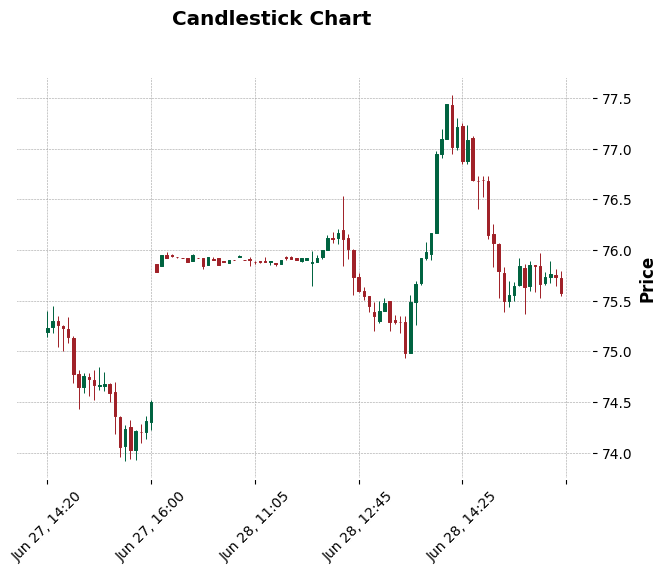

In [9]:
mpf.plot(df1.tail(100), type='candle', style='charles', title='Candlestick Chart', ylabel='Price')

Here we define the various trading parameters, the initial capital was set to 25000 USD. The leverage we used for 4x therefore our principal capital became 100000 USD. The risk was set at 1% of the whole account and the take profit was set at 10 times the difference between the opening and closing price of the first 5 min candle. We assumed a commision per share of 0.0035 USD.

In [10]:

# Define the inputs
capital = 25000           # Initial account value
leverage = 4              # Leverage multiplier
commission_per_share = 0.0035       # Comission fees and slippage
account_risk=0.01         # Percentage of total account risked per trade
profit_multiplier=10      # Profit target multiplier from entry price


#first_column_index = df.index

df = df[['open', 'high', 'low', 'close', 'volume']]
df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
df['RSI']=ta.rsi(df.Close, length=16)

df1 = df1[['open', 'high', 'low', 'close', 'volume']]
df1.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

<ipython-input-10-7128d2693803>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RSI']=ta.rsi(df.Close, length=16)


In [11]:
df1 = df1[df1.index >= '2020-01-01']

Next up, we defined a function **Apply ORB Strategy** to calculate the entry prices and exit prices for the given data.
> Each day was seperated because it is an Intraday Strategy which is most effective from the start until EOD, this was done using a *for* loop
>

1.   We defined the open price and close price using the opening range. Opening range was the first row in the data for each day.
2.   We checked using an *if* condition if the first candle is a bullish candle, bearish candle, or a doji. In each case we took a position in the same direction as the first candle and did not take a position in case it was doji
3. The **entry price** was the open of the second candle, the **stop loss** was set as the low (high) of the bullish (bearish) candle and the target profit was the calculated using entry_price + direction * profit_multiplier * abs(entry_price - stop_loss)
4. Then we iterated through each row for each day to find if we hit the stoploss or the target. If neither were achieved, the exit price was the price at the EOD. The P&L was added to the total cap and the dataframe was modified with the total capital of the day.



In [13]:
# Function to calculate ORB strategy
entry_price = None
def apply_orb_strategy(data, capital, leverage, commission_per_share):
    df_results = pd.DataFrame()
    length = (len(data.groupby(data.index.date)))
    df_results['Date'] = None
    df_results['Date'] = df_results['Date'].reindex(range(length), fill_value=None)  # Pad with zeros if needed
    df_results['ORB QQQ'] = ""
    df_results['ORB QQQ'] = df_results['ORB QQQ'].reindex(range(length), fill_value=None)  # Pad with zeros if needed
    df_results['Buy and Hold QQQ'] = ""
    df_results['Buy and Hold QQQ'] = df_results['Buy and Hold QQQ'].reindex(range(length), fill_value=None)  # Pad with zeros if needed
    buy_points = {'date':[],"price":[]}
    sell_points = {'date':[],"price":[]}
    results = []
    total_cap=capital
    count = 0
    initial_hold_quantity = capital/data['Close'][0]
    for date, day_data in data.groupby(data.index.date):
        day_data = day_data.reset_index()
        if day_data.empty or len(day_data) < 2:
            continue  # Skip if there's no data or not enough candles
        # Define the first 5-minute range
        opening_range = day_data.loc[0]
        open_price = opening_range['Open']
        high_price = opening_range['High']
        low_price = opening_range['Low']
        close_price = opening_range['Close']
        if close_price > open_price:# Bullish first candle
          entry_price = day_data.loc[1, 'Open']
          stop_loss = low_price
          direction = 1
          buy_points['date'].append(date)
          buy_points['price'].append(entry_price)

        elif close_price < open_price: # Bearish first candle
          entry_price = day_data.loc[1, 'Open']
          stop_loss = high_price
          direction = -1
          sell_points['date'].append(date)
          sell_points['price'].append(entry_price)
        else:
          direction = 0
          continue

        # Calculate risk per trade
        risk_per_trade = account_risk * capital
        # if entry_price == stop_loss:
        #   continue
        shares = risk_per_trade / abs(entry_price - stop_loss)
        shares = min(shares, capital * leverage / entry_price)  # Adjust for leverage

        profit_target = entry_price + direction * profit_multiplier * abs(entry_price - stop_loss)
        trade_commission = commission_per_share * shares

        for idx, row in day_data.iterrows():
            if idx <= 1:
                continue  # Skip the first two rows  ???????????????????????????? WHY SKIP TWO ROWS?

            current_price = row['Open']
            if direction == 1 and current_price >= profit_target:
                exit_price = profit_target
                sell_points['date'].append(date)
                sell_points['price'].append(exit_price)
                break
            elif direction == -1 and current_price <= profit_target:
                exit_price = profit_target
                buy_points['date'].append(date)
                buy_points['price'].append(exit_price)
                break
            elif direction == 1 and current_price <= stop_loss:
                exit_price = stop_loss
                sell_points['date'].append(date)
                sell_points['price'].append(exit_price)
                break
            elif direction == -1 and current_price >= stop_loss:
                exit_price = stop_loss
                buy_points['date'].append(date)
                buy_points['price'].append(exit_price)
                break
        else:
            exit_price = day_data.loc[len(day_data) - 1, 'Close']  # End of day exit
            if len(buy_points['price']) > len(sell_points['price']):
              sell_points['date'].append(date)
              sell_points['price'].append(exit_price)
            else:
              buy_points['date'].append(date)
              buy_points['price'].append(exit_price)

        trade_profit = direction * (exit_price - entry_price) * shares
        trade_profit -= trade_commission
        total_cap+=trade_profit
        results.append(total_cap)
        df_results['Date'].iloc[count] = date
        df_results['ORB QQQ'].iloc[count] = total_cap
        df_results['Buy and Hold QQQ'].iloc[count] = initial_hold_quantity*day_data.loc[len(day_data) - 1, 'Close']
        count+=1
    sell_points['date'] = pd.to_datetime(sell_points['date'])
    buy_points['date'] = pd.to_datetime(sell_points['date'])
    buy_markers = pd.Series(buy_points['price'], index=buy_points['date'])
    sell_markers = pd.Series(sell_points['price'], index=sell_points['date'])
    return df_results,buy_markers,sell_markers

# Apply the strategy
strategy_results,buy_markers,sell_markers = apply_orb_strategy(df, capital, leverage, commission_per_share)
strategy_results=strategy_results.dropna()
strategy_results['Date'] = pd.to_datetime(strategy_results['Date'])
strategy_results.set_index('Date', inplace=True)

#Apply the strategy for TQQQ
strategy_results_tqqq,buy_markers_tqqq,sell_markers_tqqq = apply_orb_strategy(df1, capital, leverage, commission_per_share)
strategy_results_tqqq=strategy_results_tqqq.dropna()
strategy_results_tqqq['Date'] = pd.to_datetime(strategy_results_tqqq['Date'])
strategy_results_tqqq.set_index('Date', inplace=True)

strategy_results_tqqq = strategy_results_tqqq[['ORB QQQ', 'Buy and Hold QQQ']]
strategy_results_tqqq.columns = ['ORB TQQQ', 'Buy and Hold TQQQ']


<ipython-input-13-8eabbc9e3a47>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_hold_quantity = capital/data['Close'][0]
<ipython-input-13-8eabbc9e3a47>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_hold_quantity = capital/data['Close'][0]
<ipython-input-13-8eabbc9e3a47>:49: RuntimeWarning: divide by zero encountered in scalar divide
  shares = risk_per_trade / abs(entry_price - stop_loss)
<ipython-input-13-8eabbc9e3a47>:49: RuntimeWarning: divide by zero encountered in scalar divide
  shares = risk_per_trade / abs(entry_price - stop_loss)
<ipython-input-13-8eabbc9e3a47>:49: RuntimeWarning: divi

In [14]:
strategy_results_tqqq

,ORB TQQQ,Buy and Hold TQQQ
Date,,
2020-01-03,24892.497713,25011.307101
2020-01-06,26272.85153,25090.456807
2020-01-07,27140.401199,25610.583446
2020-01-08,26989.839401,25486.205337
2020-01-09,27017.569777,26707.37223
...,...,...
2024-06-20,53908.921769,86499.321574
2024-06-21,53730.469691,85334.690185
2024-06-24,53550.961824,83367.254636


Next, we visualized the buy and sell points for the first 25 days on both the QQQ and TQQQ to see where the model buys and sells on different days

[*********************100%%**********************]  1 of 1 completed


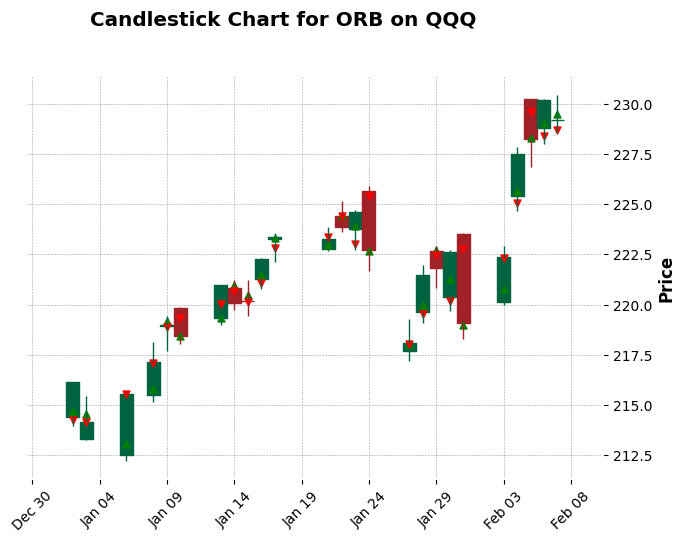

In [29]:
QQQ = yf.download("QQQ",period="1d",start="2020-1-1")
buy_markers = buy_markers.reindex(QQQ.index)
sell_markers = sell_markers.reindex(QQQ.index)
buy_markers = buy_markers.dropna()
sell_markers = sell_markers.dropna()
QQQ['Buy Price'] = buy_markers
QQQ['Sell Price'] = sell_markers
QQQ = QQQ.dropna()
buy_plot = mpf.make_addplot(QQQ.head(25)['Buy Price'], type='scatter', markersize=25, marker='^', color='green')
sell_plot = mpf.make_addplot(QQQ.head(25)['Sell Price'], type='scatter', markersize=25, marker='v', color='red')
mpf.plot(QQQ.head(25), type='candle', style='charles', title='Candlestick Chart for ORB on QQQ', ylabel='Price', addplot=[buy_plot, sell_plot], show_nontrading=True)


[*********************100%%**********************]  1 of 1 completed


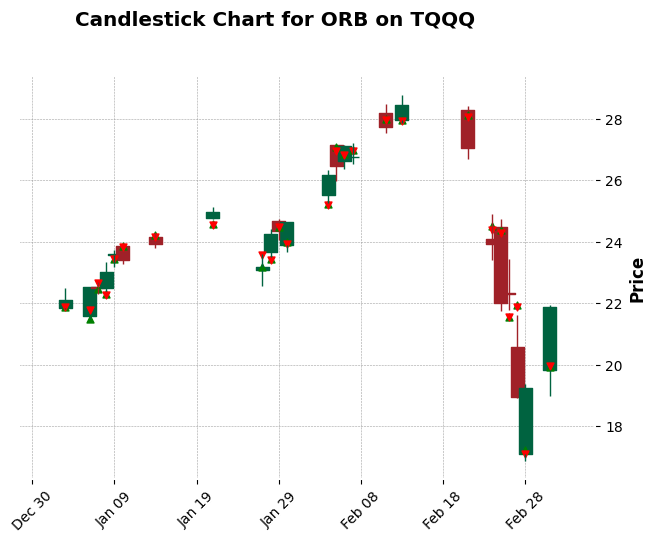

In [28]:
TQQQ = yf.download("TQQQ",period="1d",start="2020-1-1")
buy_markers_tqqq = buy_markers_tqqq.reindex(TQQQ.index)
sell_markers_tqqq = sell_markers_tqqq.reindex(TQQQ.index)
buy_markers_tqqq = buy_markers_tqqq.dropna()
sell_markers_tqqq = sell_markers_tqqq.dropna()
TQQQ['Buy Price'] = buy_markers_tqqq
TQQQ['Sell Price'] = sell_markers_tqqq
TQQQ = TQQQ.dropna()
buy_plot = mpf.make_addplot(TQQQ.head(25)['Buy Price'], type='scatter', markersize=25, marker='^', color='green')
sell_plot = mpf.make_addplot(TQQQ.head(25)['Sell Price'], type='scatter', markersize=25, marker='v', color='red')
mpf.plot(TQQQ.head(25), type='candle', style='charles', title='Candlestick Chart for ORB on TQQQ', ylabel='Price', addplot=[buy_plot, sell_plot], show_nontrading=True)


Then we attempted to find the days on which we get the highest positive profit which could later be implemented in position sizing when we are not using all of our capital in every position

In [18]:
strategy_results["ORB PnL"] = 0
for i in range(1,len(strategy_results)):
  strategy_results["ORB PnL"].iloc[i] = strategy_results["ORB QQQ"].iloc[i]-strategy_results["ORB QQQ"].iloc[i-1]
day_of_week = strategy_results.index.day_name()
strategy_results['Day of Week'] = day_of_week
strategy_results

<ipython-input-18-1a795a788b57>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strategy_results["ORB PnL"].iloc[i] = strategy_results["ORB QQQ"].iloc[i]-strategy_results["ORB QQQ"].iloc[i-1]
<ipython-input-18-1a795a788b57>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-76.25968992247726' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  strategy_results["ORB PnL"].iloc[i] = strategy_results["ORB QQQ"].iloc[i]-strategy_results["ORB QQQ"].iloc[i-1]


,ORB QQQ,Buy and Hold QQQ,ORB PnL,Day of Week
Date,,,,
2020-01-02,24779.490523,25164.159642,0.000000,Thursday
2020-01-03,24703.230833,24935.966097,-76.259690,Friday
2020-01-06,25443.140472,25093.140223,739.909639,Monday
2020-01-08,25941.794318,25277.092162,498.653846,Wednesday
2020-01-09,25812.500039,25500.593769,-129.294279,Thursday
...,...,...,...,...
2023-12-21,98601.043651,47478.228473,-248.833783,Thursday
2023-12-22,98465.703651,47545.755134,-135.340000,Friday
2023-12-26,98738.180223,47836.81833,272.476572,Tuesday


Aggregating the data based on the days of the week, we see that Tuesday and Friday were the most profitable days. We also see that around 75% of the trades taken were negative but they were cut short by the stoplosses. The profitable trades of 25% prove that the profit per profitable trade far outdoes the loss per non-profitable trade

In [19]:
strategy_results['Positive'] = strategy_results["ORB PnL"]>0
strategy_results['Negative'] = strategy_results["ORB PnL"]<0
weekly_pnl = strategy_results.groupby('Day of Week')['ORB PnL'].sum()
counts = strategy_results.groupby('Day of Week').agg(
    Positive_Count=('Positive', 'sum'),
    Negative_Count=('Negative', 'sum')
)
print(counts)
print("\n",weekly_pnl)


             Positive_Count  Negative_Count
Day of Week                                
Friday                   63             137
Monday                   52             131
Thursday                 54             150
Tuesday                  72             132
Wednesday                51             157

 Day of Week
Friday       20246.740127
Monday        6165.614571
Thursday     13881.072998
Tuesday      26631.893691
Wednesday     7135.767822
Name: ORB PnL, dtype: float64


I used the Matplotlib library to visualize each of the strategy's capital movement from Jan 1 2020.

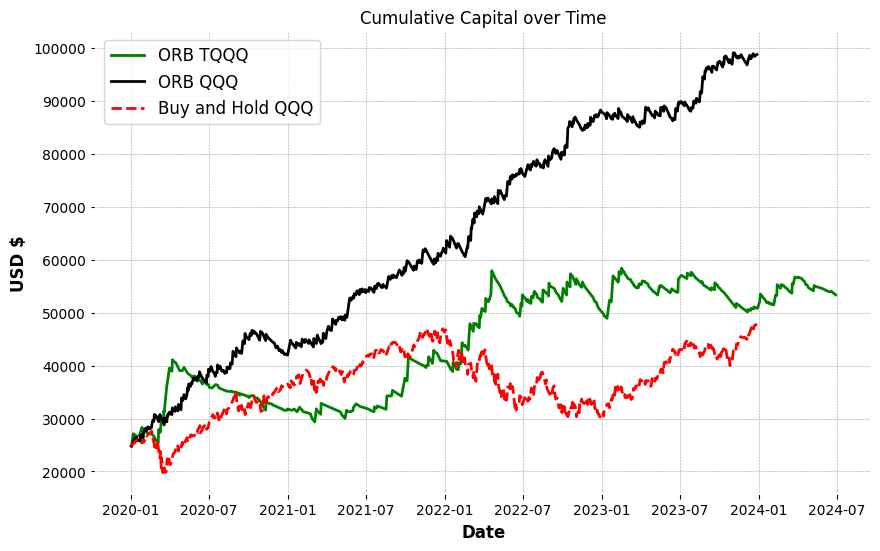

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(strategy_results_tqqq['ORB TQQQ'], label = "ORB TQQQ", color='green')
plt.plot(strategy_results['ORB QQQ'], label = "ORB QQQ", color='black')
plt.plot(strategy_results['Buy and Hold QQQ'], label = "Buy and Hold QQQ" , color='red',linestyle = "--")
#plt.plot(strategy_results_tqqq['Buy and Hold TQQQ'], label = "Buy and Hold TQQQ" , color='blue',linestyle = "--")
# Adding labels and title
plt.xlabel('Date')
plt.ylabel('USD $')
plt.title('Cumulative Capital over Time')
plt.legend(loc='upper left',fontsize='large')
plt.grid(True)

# Show the plot
plt.show()

According to this, ORB on QQQ promises us with the best and consistent results over time

In [21]:
Cumulative_Returns_ORB = 100*(strategy_results["ORB QQQ"][-1]-25000)/25000
print("ORB Strategy Final Total Capital: {} $".format((strategy_results["ORB QQQ"][-1]).round(2)))
print(f"Total Cumulative Returns ORB Strategy {Cumulative_Returns_ORB.round(2)}%")
print("Buy and Hold Final Total Capital: {} $".format((strategy_results["Buy and Hold QQQ"][-1]).round(2)))
Cum_Returns_BuyaandHold = (100*(strategy_results["Buy and Hold QQQ"][-1]-25000)/25000).round(2)
print(f"Total Cumulative Returns Buy and Hold: {Cum_Returns_BuyaandHold}%")


ORB Strategy Final Total Capital: 98840.58 $
Total Cumulative Returns ORB Strategy 295.36%
Buy and Hold Final Total Capital: 47885.72 $
Total Cumulative Returns Buy and Hold: 91.54%


<ipython-input-21-5c4da8335e04>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Cumulative_Returns_ORB = 100*(strategy_results["ORB QQQ"][-1]-25000)/25000
<ipython-input-21-5c4da8335e04>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("ORB Strategy Final Total Capital: {} $".format((strategy_results["ORB QQQ"][-1]).round(2)))
<ipython-input-21-5c4da8335e04>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Buy and Hold

In [26]:
Cumulative_Returns_ORB = 100*(strategy_results_tqqq["ORB TQQQ"][-1]-25000)/25000
print("ORB Strategy Final Total Capital: {} $".format((strategy_results_tqqq["ORB TQQQ"][-1]).round(2)))
print(f"Total Cumulative Returns ORB Strategy {Cumulative_Returns_ORB.round(2)}%")
print("Buy and Hold Final Total Capital: {} $".format((strategy_results_tqqq["Buy and Hold TQQQ"][-1]).round(2)))
Cum_Returns_BuyaandHold = (100*(strategy_results_tqqq["Buy and Hold TQQQ"][-1]-25000)/25000).round(2)
print(f"Total Cumulative Returns Buy and Hold: {Cum_Returns_BuyaandHold}%")

ORB Strategy Final Total Capital: 53378.04 $
Total Cumulative Returns ORB Strategy 113.51%
Buy and Hold Final Total Capital: 85459.07 $
Total Cumulative Returns Buy and Hold: 241.84%


<ipython-input-26-3b3b9aeeab48>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Cumulative_Returns_ORB = 100*(strategy_results_tqqq["ORB TQQQ"][-1]-25000)/25000
<ipython-input-26-3b3b9aeeab48>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("ORB Strategy Final Total Capital: {} $".format((strategy_results_tqqq["ORB TQQQ"][-1]).round(2)))
<ipython-input-26-3b3b9aeeab48>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("

Doing some performance analysis using quantstats library

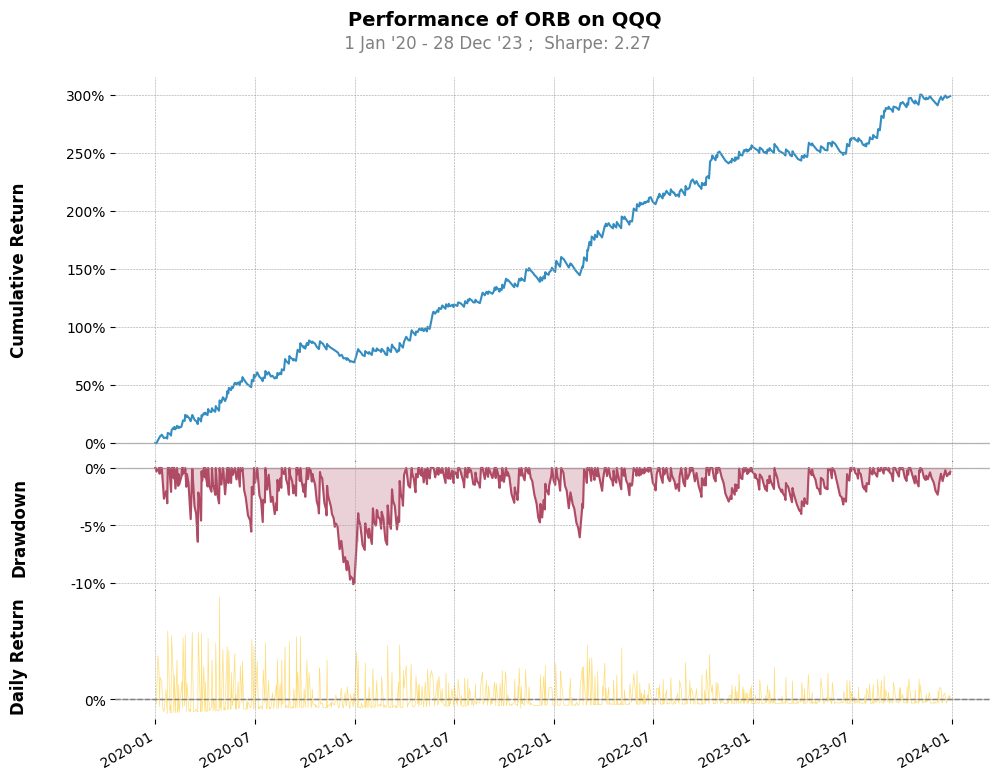

In [27]:
qs.plots.snapshot(strategy_results["ORB QQQ"], title='Performance of ORB on QQQ', show=True)

Analysing the full reports here are the key insights one can gain:
1. The strategy performed better than benchmark throughout the time frame
> This was much more pronounced when the volatility was matched
2. The sharpe ratio (risk-free returns) averaged around 2 over the years which tells us that this strategy returns more than it actually risks.
3. The worst drawdown period included the Covid Crash which is shown by a -10% in the underwater plot. Otherwise the returns were mostly positive with some negative weeks.

[*********************100%%**********************]  1 of 1 completed


[Performance Metrics]



/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2020-01-03   2020-01-03
End Period                 2023-12-28   2023-12-28
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          90.28%       298.88%
CAGR﹪                     11.79%       27.08%

Sharpe                     0.73         2.27
Prob. Sharpe Ratio         92.52%       100.0%
Smart Sharpe               0.65         2.03
Sortino                    1.03         6.59
Smart Sortino              0.92         5.89
Sortino/√2                 0.73         4.66
Smart Sortino/√2           0.65         4.16
Omega                      1.55         1.55

Max Drawdown               -35.62%      -10.11%
Longest DD Days            753          172
Volatility (ann.)          27.35%       15.94%
R^2                        0.0          0.0
Information Ratio          0.03         0.03
Calmar             

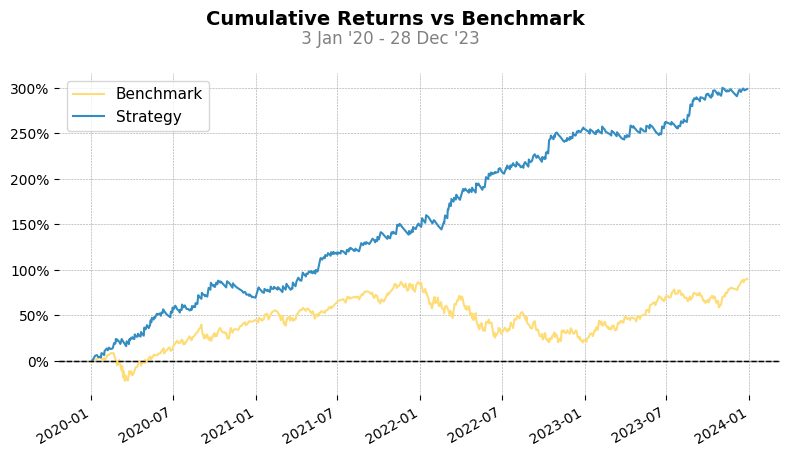

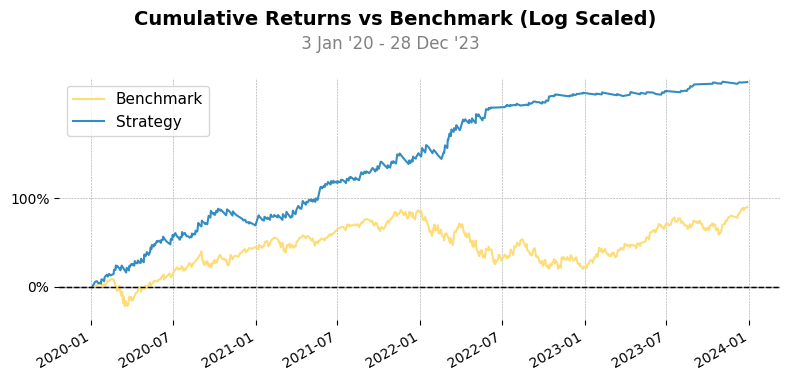

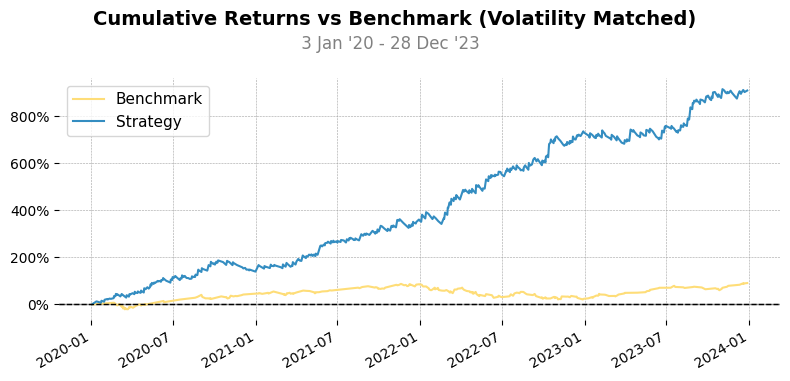

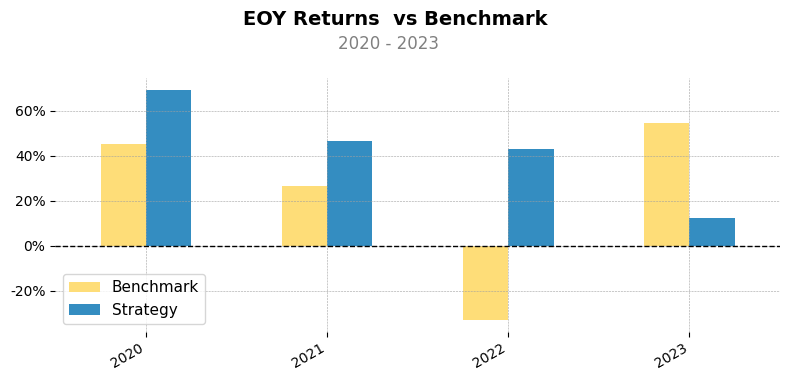

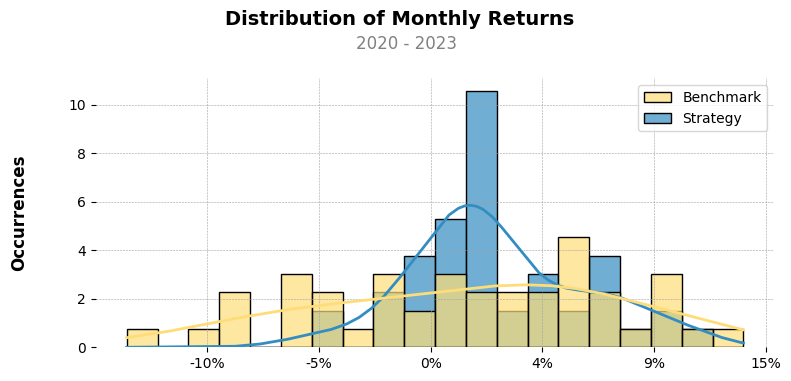

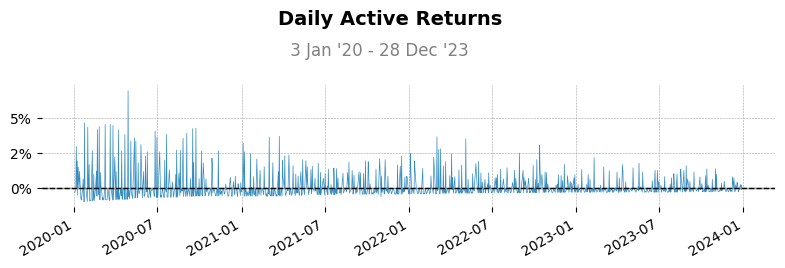

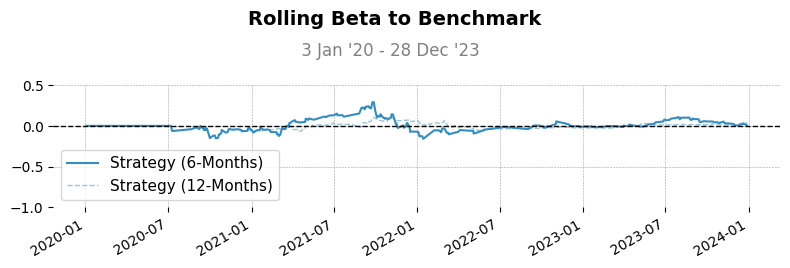

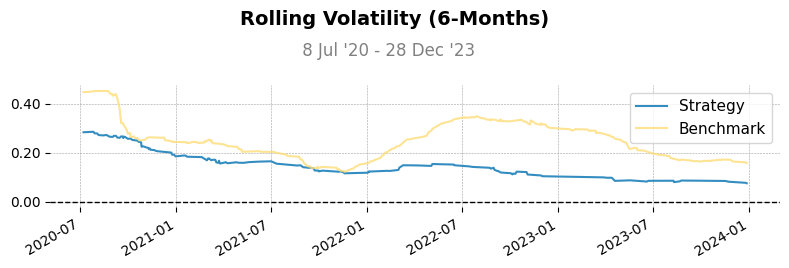

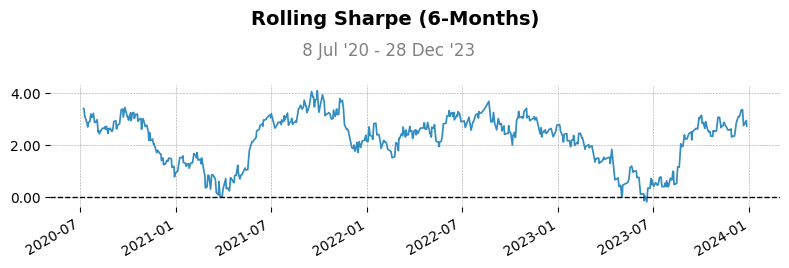

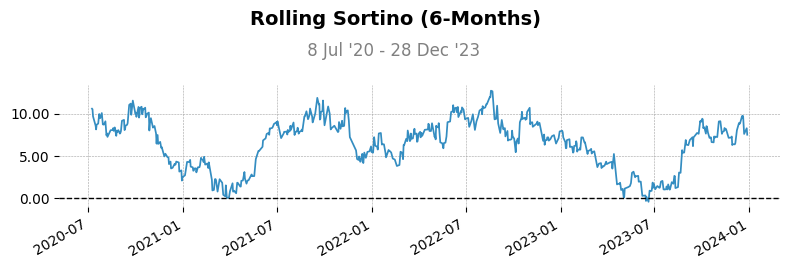

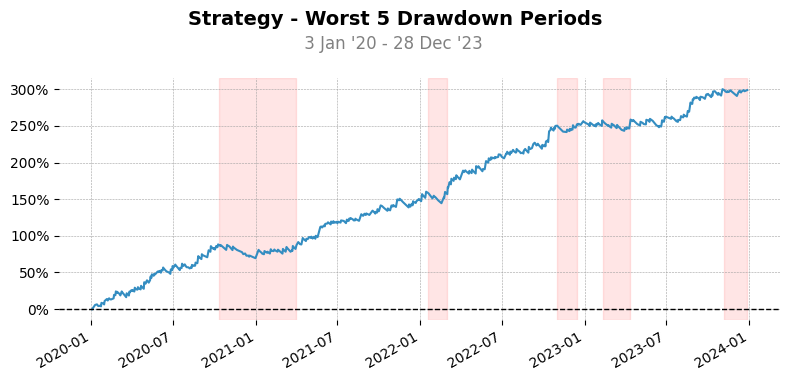

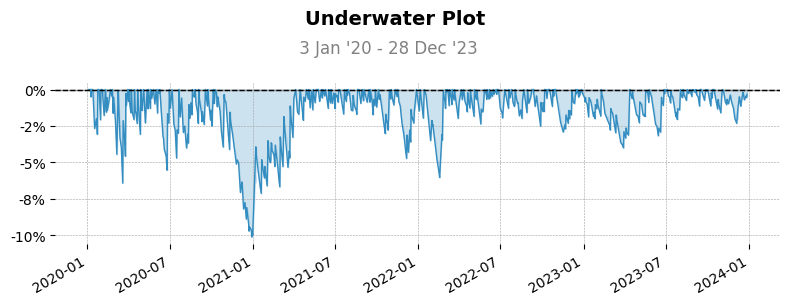

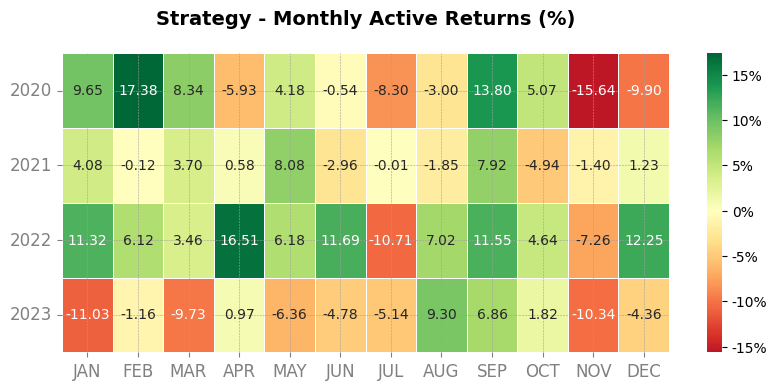

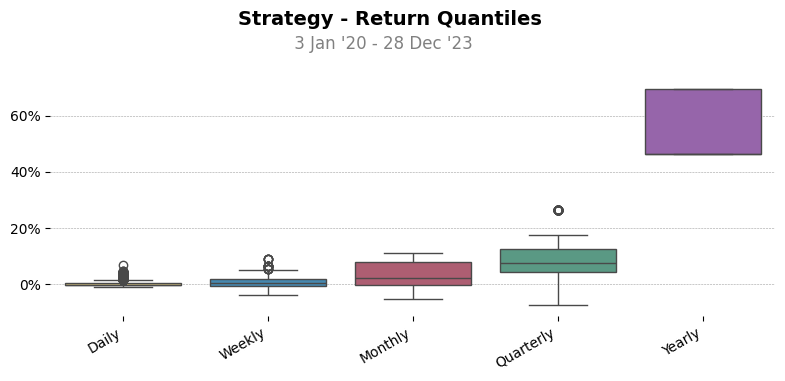

In [30]:
qs.reports.full(strategy_results["ORB QQQ"], benchmark='QQQ')

In [ ]:
# Calculate the mean and standard deviation of strategy returns
mean_return = np.mean(strategy_results["ORB QQQ"])
std_return = np.std(strategy_results["ORB QQQ"])

# Calculate Z-Score for a specific return (e.g., first return in the strategy returns)
specific_return = strategy_results["ORB QQQ"][0]
z_score = (specific_return - mean_return) / std_return

print("Z-Score:", z_score)


Z-Score: -1.9450327546743051
